In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.layers import TimeDistributed, GlobalAveragePooling1D, GlobalAveragePooling2D, BatchNormalization
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, AveragePooling1D
from keras.layers import Embedding
from keras.layers import Dropout, Flatten, Bidirectional, Dense, Activation, TimeDistributed
from keras.models import Model, Sequential
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import KeyedVectors
import itertools, nltk, snowballstemmer, re

LabeledSentence = TaggedDocument

In [2]:
import random

class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        
        flipped = {}
        
        # make sure that keys are unique
        for key, value in sources.items():
            if value not in flipped:
                flipped[value] = [key]
            else:
                raise Exception('Non-unique prefix encountered')
    
    def __iter__(self):
        for source, prefix in self.sources.items():
            with to_categorical.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    yield LabeledSentence(to_categorical.to_unicode(line).split(), [prefix + '_%s' % item_no])
    
    def to_array(self):
        self.sentences = []
        for source, prefix in self.sources.items():
            with to_categorical.smart_open(source) as fin:
                for item_no, line in enumerate(fin):
                    self.sentences.append(LabeledSentence(to_categorical.to_unicode(line).split(), [prefix + '_%s' % item_no]))
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [3]:
data = pd.read_csv("dataset/deceptive-opinion.csv")

In [4]:
data['polarity'] = np.where(data['polarity']=='positive', 1, 0)
data['deceptive'] = np.where(data['deceptive']=='truthful', 1, 0)

In [5]:
data.head()

,deceptive,hotel,polarity,source,text
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...


In [6]:
df = data.sample(frac=1)

In [7]:
df.head()

,deceptive,hotel,polarity,source,text
618,0,hardrock,1,MTurk,Hard Rock Hotel is a must to visit. No matter ...
1084,1,hilton,0,Web,I stayed at the Hilton Chicago because I was a...
1074,1,james,0,Web,My parents booked five nights at The James for...
986,1,hardrock,0,Web,We stayed at this Hotel in February 2010. The ...
318,1,james,1,TripAdvisor,My significant other and I recently spent 3 ni...


In [8]:
df.describe()

,deceptive,polarity
count,1600.000000,1600.000000
mean,0.500000,0.500000
std,0.500156,0.500156
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.500000,0.500000
75%,1.000000,1.000000
max,1.000000,1.000000


In [9]:
def create_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return [1,1]
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return [1,0]
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return [0,1]
    else:
        return [0,0]
    
def specific_class(c):
    if c['polarity'] == 1 and c['deceptive'] == 1:
        return "TRUE_POSITIVE"
    elif c['polarity'] == 1 and c['deceptive'] == 0:
        return "FALSE_POSITIVE"
    elif c['polarity'] == 0 and c['deceptive'] == 1:
        return "TRUE_NEGATIVE"
    else:
        return "FALSE_NEGATIVE"

data['final_class'] = data.apply(create_class, axis=1)
data['given_class'] = data.apply(specific_class, axis=1)

In [10]:
data['final_class']

0       [1, 1]
1       [1, 1]
2       [1, 1]
3       [1, 1]
4       [1, 1]
         ...  
1595    [0, 0]
1596    [0, 0]
1597    [0, 0]
1598    [0, 0]
1599    [0, 0]
Name: final_class, Length: 1600, dtype: object

In [11]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",TRUE_POSITIVE
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",TRUE_POSITIVE
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",TRUE_POSITIVE
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",TRUE_POSITIVE
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",TRUE_POSITIVE


In [12]:
from sklearn import preprocessing 
  
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
data['given_class']= label_encoder.fit_transform(data['given_class']) 

In [13]:
data['given_class'].unique()

array([3, 1, 2, 0])

In [14]:
Y = data['given_class']
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = to_categorical(encoded_Y)

In [15]:
data.head()

,deceptive,hotel,polarity,source,text,final_class,given_class
0,1,conrad,1,TripAdvisor,We stayed for a one night getaway with family ...,"[1, 1]",3
1,1,hyatt,1,TripAdvisor,Triple A rate with upgrade to view room was le...,"[1, 1]",3
2,1,hyatt,1,TripAdvisor,This comes a little late as I'm finally catchi...,"[1, 1]",3
3,1,omni,1,TripAdvisor,The Omni Chicago really delivers on all fronts...,"[1, 1]",3
4,1,hyatt,1,TripAdvisor,I asked for a high floor away from the elevato...,"[1, 1]",3


In [16]:
textData = pd.DataFrame(list(data['text']))

In [17]:
stemmer = snowballstemmer.EnglishStemmer()

# grab stopword list, extend it a bit, and then turn it into a set for later
stop = stopwords.words('english')
stop.extend(['may','also','zero','one','two','three','four','five','six','seven','eight','nine','ten','across','among','beside','however','yet','within']+list(ascii_lowercase))
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [18]:
# remove characters and stoplist words, then generate dictionary of unique words
textData[0].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ',inplace=True,regex=True)
wordlist = filter(None, " ".join(list(set(list(itertools.chain(*textData[0].str.split(' ')))))).split(" "))
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in textData[0].str.lower().str.split(' ')]

In [19]:
# remove all words that don't occur at least 5 times and then stem the resulting docs
minimum_count = 1
str_frequencies = pd.DataFrame(list(Counter(filter(None,list(itertools.chain(*data['stemmed_text_data'].str.split(' '))))).items()),columns=['word','count'])
low_frequency_words = set(str_frequencies[str_frequencies['count'] < minimum_count]['word'])
data['stemmed_text_data'] = [' '.join(filter(None,filter(lambda word: word not in low_frequency_words, line))) for line in data['stemmed_text_data'].str.split(' ')]
data['stemmed_text_data'] = [" ".join(stemmer.stemWords(re.sub('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\]',' ', next_text).split(' '))) for next_text in data['stemmed_text_data']]    

In [20]:
lmtzr = WordNetLemmatizer()
w = re.compile("\w+",re.I)

def label_sentences(df, input_point):
    labeled_sentences = []
    list_sen = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w,datapoint[input_point].lower())
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index]))
        list_sen.append(tokenized_words)
    return labeled_sentences, list_sen

def train_doc2vec_model(labeled_sentences):
    model = Doc2Vec(min_count=1, window=9, vector_size=512, sample=1e-4, negative=5, workers=7)
    model.build_vocab(labeled_sentences)
    pretrained_weights = model.wv.vectors
    vocab_size, embedding_size = pretrained_weights.shape
    model.train(labeled_sentences, total_examples=vocab_size, epochs=400)
    
    return model

In [21]:
textData = data['stemmed_text_data'].to_frame().reset_index()
sen, corpus = label_sentences(textData, 'stemmed_text_data')

In [22]:
doc2vec_model = train_doc2vec_model(sen)

In [23]:
doc2vec_model.save("doc2vec_model_opinion_corpus.d2v")

In [24]:
doc2vec_model = Doc2Vec.load("doc2vec_model_opinion_corpus.d2v") 

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

tfidf1 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,1))
result_train1 = tfidf1.fit_transform(corpus)

tfidf2 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,2))
result_train2 = tfidf2.fit_transform(corpus)

tfidf3 = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, ngram_range=(1,3))
result_train3 = tfidf3.fit_transform(corpus)

svd = TruncatedSVD(n_components=512, n_iter=40, random_state=34)
tfidf_data1 = svd.fit_transform(result_train1)
tfidf_data2 = svd.fit_transform(result_train2)
tfidf_data3 = svd.fit_transform(result_train3)

d:\Aplikasi\Program\python\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
import spacy

nlp = spacy.load('en_core_web_sm')
temp_textData = pd.DataFrame(list(data['text']))

overall_pos_tags_tokens = []
overall_pos = []
overall_tokens = []
overall_dep = []

for i in range(1600):
    doc = nlp(temp_textData[0][i])
    given_pos_tags_tokens = []
    given_pos = []
    given_tokens = []
    given_dep = []
    for token in doc:
        output = "%s_%s" % (token.pos_, token.tag_)
        given_pos_tags_tokens.append(output)
        given_pos.append(token.pos_)
        given_tokens.append(token.tag_)
        given_dep.append(token.dep_)
        
    overall_pos_tags_tokens.append(given_pos_tags_tokens)
    overall_pos.append(given_pos)
    overall_tokens.append(given_tokens)
    overall_dep.append(given_dep)


In [27]:
from sklearn.preprocessing import MinMaxScaler

count = CountVectorizer(tokenizer=lambda i:i, lowercase=False)
pos_tags_data = count.fit_transform(overall_pos_tags_tokens).todense()
pos_data = count.fit_transform(overall_pos).todense()
tokens_data = count.fit_transform(overall_tokens).todense()
dep_data = count.fit_transform(overall_dep).todense()
min_max_scaler = MinMaxScaler()
normalized_pos_tags_data = min_max_scaler.fit_transform(np.asarray(pos_tags_data))
normalized_pos_data = min_max_scaler.fit_transform(np.asarray(pos_data))
normalized_tokens_data = min_max_scaler.fit_transform(np.asarray(tokens_data))
normalized_dep_data = min_max_scaler.fit_transform(np.asarray(dep_data))

final_pos_tags_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_tokens_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_dep_data = np.zeros(shape=(1600, 512)).astype(np.float32)
final_pos_tags_data[:normalized_pos_tags_data.shape[0],:normalized_pos_tags_data.shape[1]] = normalized_pos_tags_data
final_pos_data[:normalized_pos_data.shape[0],:normalized_pos_data.shape[1]] = normalized_pos_data
final_tokens_data[:normalized_tokens_data.shape[0],:normalized_tokens_data.shape[1]] = normalized_tokens_data
final_dep_data[:normalized_dep_data.shape[0],:normalized_dep_data.shape[1]] = normalized_dep_data

d:\Aplikasi\Program\python\lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [28]:
maxlength = []
for i in range(0,len(sen)):
    maxlength.append(len(sen[i][0]))
    
print(max(maxlength))   

370


In [29]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        label = 'SENT_%s' %i
        comments.append(d2v_model.docvecs[label])
    df['vectorized_comments'] = comments
    
    return df

textData = vectorize_comments(textData,doc2vec_model)
print (textData.head(2))

   index                                  stemmed_text_data  \
0      0  stay night getaway famili thursday tripl aaa r...   
1      1  tripl rate upgrad view room less $ includ brea...   

                                 vectorized_comments  
0  [0.07601746, -0.4517467, 0.63034666, 0.1424411...  
1  [-0.0065358384, -0.22216755, 0.3980428, -0.020...  


C:\Users\axioo\AppData\Local\Temp\ipykernel_13256\1247476273.py:6: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  comments.append(d2v_model.docvecs[label])


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV 

X_train, X_test, y_train, y_test = train_test_split(textData["vectorized_comments"].T.tolist(), 
                                                                     dummy_y, 
                                                                     test_size=0.1, 
                                                                     random_state=56)

In [31]:
X = np.array(textData["vectorized_comments"].T.tolist()).reshape((1,1600,512))
y = np.array(dummy_y).reshape((1600,4))
X_train2 = np.array(X_train).reshape((1,1440,512))
y_train2 = np.array(y_train).reshape((1,1440,4))
X_test2 = np.array(X_test).reshape((1,160,512))
y_test2 = np.array(y_test).reshape((1,160,4))

In [32]:
from sklearn.model_selection import StratifiedKFold
Xtemp = textData["vectorized_comments"].T.tolist()
ytemp = data['given_class']
training_indices = []
testing_indices = []

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(Xtemp, ytemp)

for train_index, test_index in skf.split(Xtemp, ytemp):
    training_indices.append(train_index)
    testing_indices.append(test_index)

In [33]:
def extractTrainingAndTestingData(givenIndex):
    X_train3 = np.zeros(shape=(1440, max(maxlength)+10, 512)).astype(np.float32)
    Y_train3 = np.zeros(shape=(1440, 4)).astype(np.float32)
    X_test3 = np.zeros(shape=(160, max(maxlength)+10, 512)).astype(np.float32)
    Y_test3 = np.zeros(shape=(160, 4)).astype(np.float32)

    empty_word = np.zeros(512).astype(np.float32)

    count_i = 0
    for i in training_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_train3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_train3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_train3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_train3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_train3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_train3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_train3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_train3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_train3[count_i,j,:] = final_pos_tags_data[i] 
            elif j == len1+7:
                X_train3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_train3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_train3[count_i,j,:] = final_dep_data[i]
            else:
                X_train3[count_i,j,:] = empty_word

        Y_train3[count_i,:] = dummy_y[i]
        count_i += 1


    count_i = 0
    for i in testing_indices[givenIndex]:
        len1 = len(sen[i][0])
        average_vector1 = np.zeros(512).astype(np.float32)
        average_vector2 = np.zeros(512).astype(np.float32)
        average_vector3 = np.zeros(512).astype(np.float32)
        for j in range(max(maxlength)+10):
            if j < len1:
                X_test3[count_i,j,:] = doc2vec_model[sen[i][0][j]]
                average_vector1 += result_train1[i, tfidf1.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
                average_vector2 += result_train2[i, tfidf2.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]  
                average_vector3 += result_train3[i, tfidf3.vocabulary_[sen[i][0][j]]] * doc2vec_model[sen[i][0][j]]
            #elif j >= len1 and j < len1 + 379:
            #    X_test3[count_i,j,:] = glove_data[i, j-len1, :]
            elif j == len1:
                X_test3[count_i,j,:] = tfidf_data1[i]
            elif j == len1 + 1:
                X_test3[count_i,j,:] = tfidf_data2[i]
            elif j == len1+2:
                X_test3[count_i,j,:] = tfidf_data3[i]
            elif j == len1+3:
                X_test3[count_i,j,:] = average_vector1
            elif j == len1+4:
                X_test3[count_i,j,:] = average_vector2
            elif j == len1+5:
                X_test3[count_i,j,:] = average_vector3
            elif j == len1+6:
                X_test3[count_i,j,:] = final_pos_tags_data[i]
            elif j == len1+7:
                X_test3[count_i,j,:] = final_pos_data[i]
            elif j == len1+8:
                X_test3[count_i,j,:] = final_tokens_data[i]
            elif j == len1+9:
                X_test3[count_i,j,:] = final_dep_data[i]
            else:
                X_test3[count_i,j,:] = empty_word

        Y_test3[count_i,:] = dummy_y[i]
        count_i += 1
        
    return X_train3, X_test3, Y_train3, Y_test3
    

In [34]:
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=9, padding='same', activation='relu', input_shape=(max(maxlength)+10,512)))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=7, padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.25))
model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))
#model.add(Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(Dropout(0.25))
#model.add(MaxPooling1D(pool_size=2))
#model.add(Dropout(0.25))

#model.add(Bidirectional(LSTM(50, dropout=0.3, recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(50, dropout=0.25, recurrent_dropout=0.2)))
model.add(Dense(4, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(model.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 380, 128)          589952    
                                                                 
 dropout (Dropout)           (None, 380, 128)          0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 190, 128)          0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 190, 128)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 190, 128)          114816    
                                                                 
 dropout_2 (Dropout)         (None, 190, 128)          0         
                                                     

In [35]:
from sklearn.metrics import accuracy_score
from keras.callbacks import ModelCheckpoint 

final_accuracies = []
    
filename = 'weights.best.from_scratch%s.hdf5' % 9
checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
X_train3, X_test3, Y_train3, Y_test3 = extractTrainingAndTestingData(9)

In [36]:
history = model.fit(X_train3, Y_train3, epochs=5, batch_size=512, callbacks=[checkpointer], validation_data=(X_test3, Y_test3), verbose=1)

Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 0.6116 - accuracy: 0.2639
Epoch 1: val_loss improved from inf to 0.56189, saving model to weights.best.from_scratch9.hdf5


d:\Aplikasi\Program\python\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 39s 10s/step - loss: 0.6116 - accuracy: 0.2639 - val_loss: 0.5619 - val_accuracy: 0.2188
Epoch 2/5
3/3 [==============================] - ETA: 0s - loss: 0.5660 - accuracy: 0.2632
Epoch 2: val_loss did not improve from 0.56189
3/3 [==============================] - 16s 5s/step - loss: 0.5660 - accuracy: 0.2632 - val_loss: 0.5654 - val_accuracy: 0.2500
Epoch 3/5
3/3 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.2924
Epoch 3: val_loss improved from 0.56189 to 0.56080, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 16s 5s/step - loss: 0.5620 - accuracy: 0.2924 - val_loss: 0.5608 - val_accuracy: 0.2500
Epoch 4/5
3/3 [==============================] - ETA: 0s - loss: 0.5579 - accuracy: 0.3229
Epoch 4: val_loss improved from 0.56080 to 0.54256, saving model to weights.best.from_scratch9.hdf5
3/3 [==============================] - 16s 5s/step - loss: 0.5579 - accuracy: 0.3229 - val_loss: 0

In [37]:
model.evaluate(X_test3, Y_test3)

5/5 [==============================] - 1s 105ms/step - loss: 0.5211 - accuracy: 0.4938


[0.5210990309715271, 0.4937500059604645]

In [38]:
import matplotlib.pyplot as plt

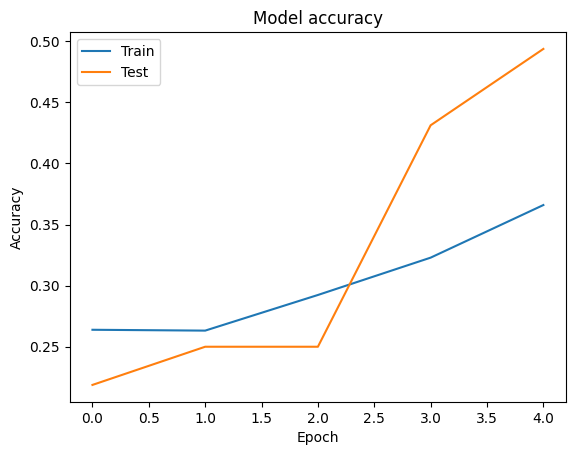

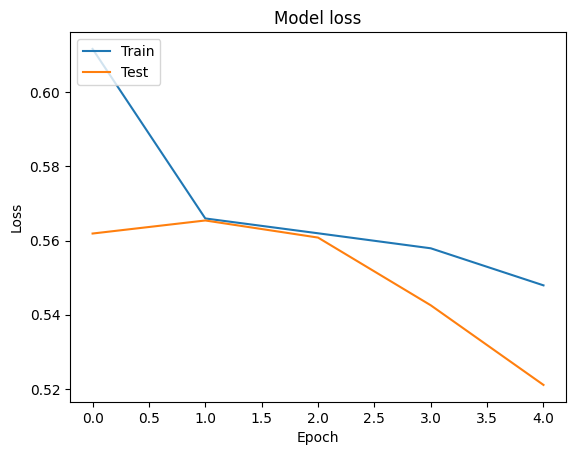

In [39]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])  # use 'accuracy' instead of 'acc'
plt.plot(history.history['val_accuracy'])  # use 'val_accuracy' instead of 'val_acc'
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()